# **Avocado price forecast**

## **Import the Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from utils import tsplot, predictions_plot


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data = pd.read_csv('../data/avocado.csv')
data = data.drop('Unnamed: 0',axis = 1)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


## **Data Info**

In [3]:
data.shape

(18249, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


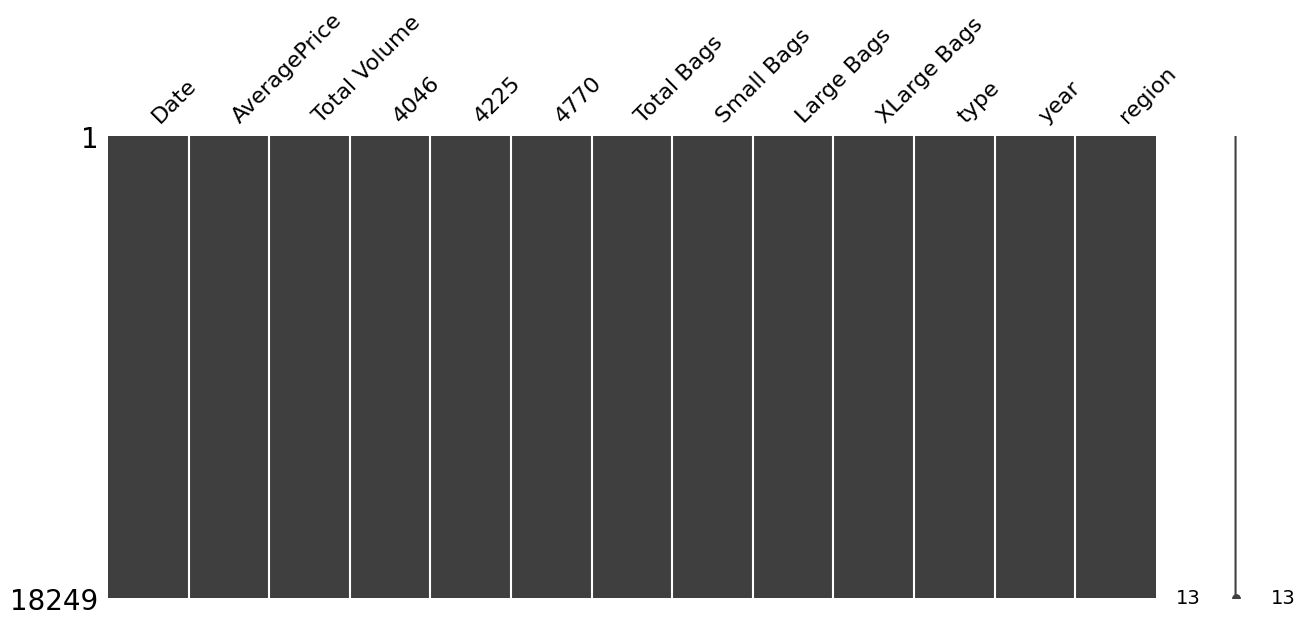

In [5]:
msno.matrix(data, figsize=(15, 6))
plt.show()

- No null values present in the data

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AveragePrice,18249.00,1.41,0.40,0.44,1.10,1.37,1.66,3.25
Total Volume,18249.00,850644.01,3453545.36,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.00,293008.42,1264989.08,0.00,854.07,8645.30,111020.20,22743616.17
4225,18249.00,295154.57,1204120.40,0.00,3008.78,29061.02,150206.86,20470572.61
4770,18249.00,22839.74,107464.07,0.00,0.00,184.99,6243.42,2546439.11
Total Bags,18249.00,239639.20,986242.40,0.00,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.00,182194.69,746178.51,0.00,2849.42,26362.82,83337.67,13384586.80
Large Bags,18249.00,54338.09,243965.96,0.00,127.47,2647.71,22029.25,5719096.61
XLarge Bags,18249.00,3106.43,17692.89,0.00,0.00,0.00,132.50,551693.65
year,18249.00,2016.15,0.94,2015.00,2015.00,2016.00,2017.00,2018.00


### **Time Series Dataset**

In [7]:
df1 = data[['Date', 'AveragePrice']]

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)

df1 = df1.resample('W').mean()
df1

,AveragePrice
Date,
2015-01-04,1.30
2015-01-11,1.37
2015-01-18,1.39
2015-01-25,1.40
2015-02-01,1.25
...,...
2018-02-25,1.36
2018-03-04,1.35
2018-03-11,1.34


### **Target Variable Visualization**

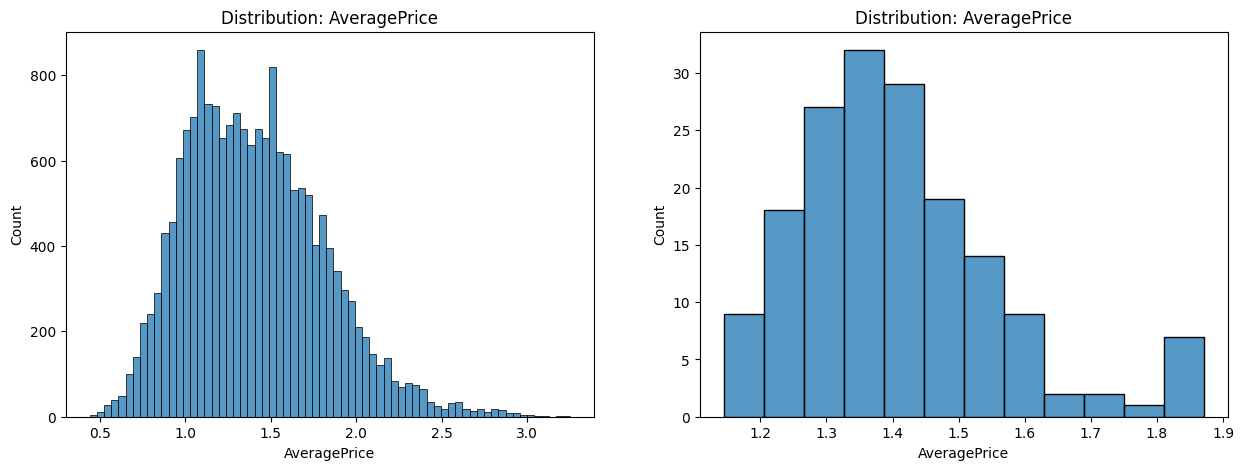

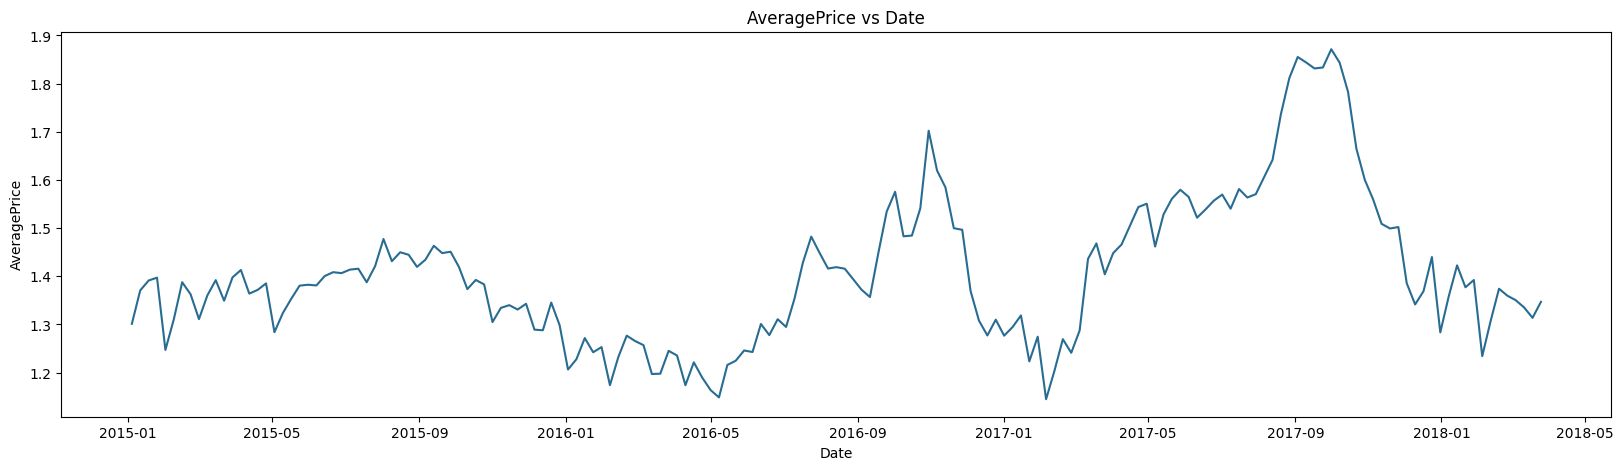

In [8]:
color1 = ['#296C92', '#3EB489']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['AveragePrice'])
plt.title('Distribution: AveragePrice')

plt.subplot(1, 2, 2)
sns.histplot(df1['AveragePrice'])
plt.title('Distribution: AveragePrice')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

plt.subplot(1, 1, 1)
sns.lineplot(x=df1.index, y='AveragePrice', data=df1, color=color1[0])
plt.title('AveragePrice vs Date')

plt.show()
fig.tight_layout(pad=2)

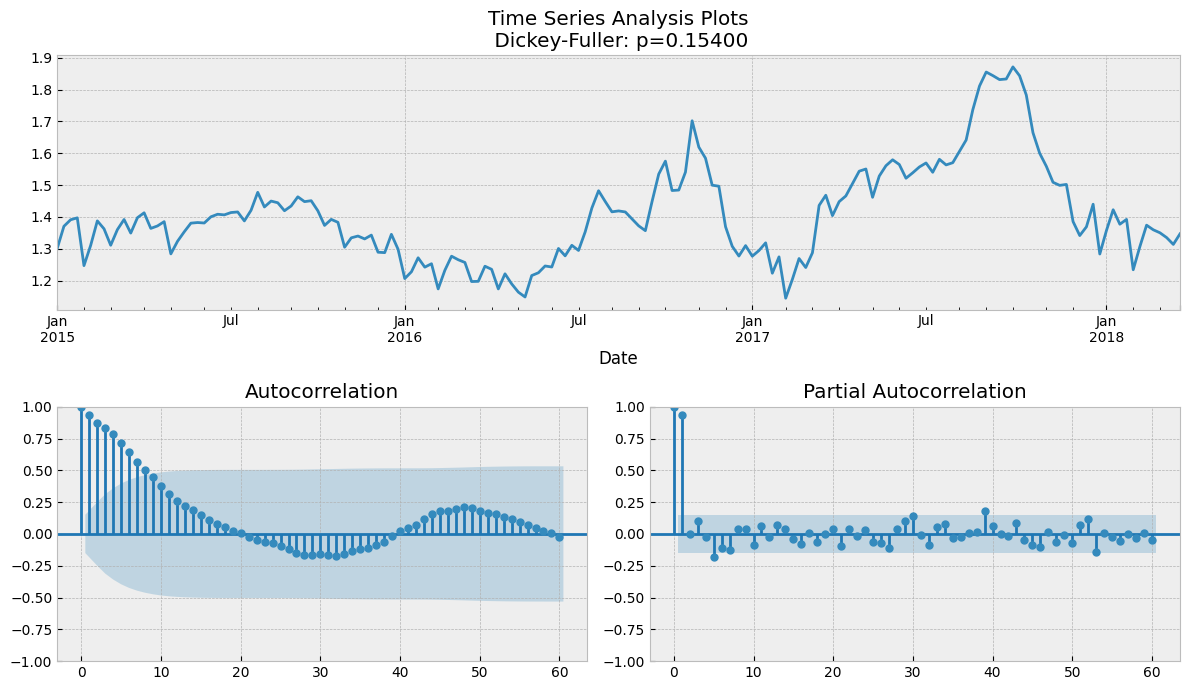

In [9]:
tsplot(df1['AveragePrice'], lags = 60)

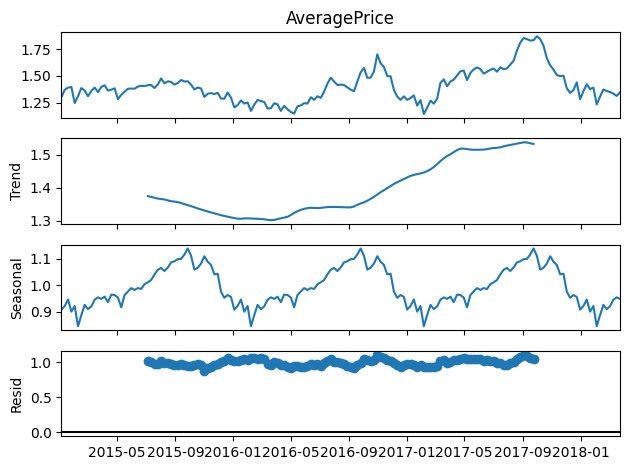

In [10]:
seasonal_decompose(df1['AveragePrice'], model = 'multiplicative').plot()
plt.show();

## **Train/Test split**

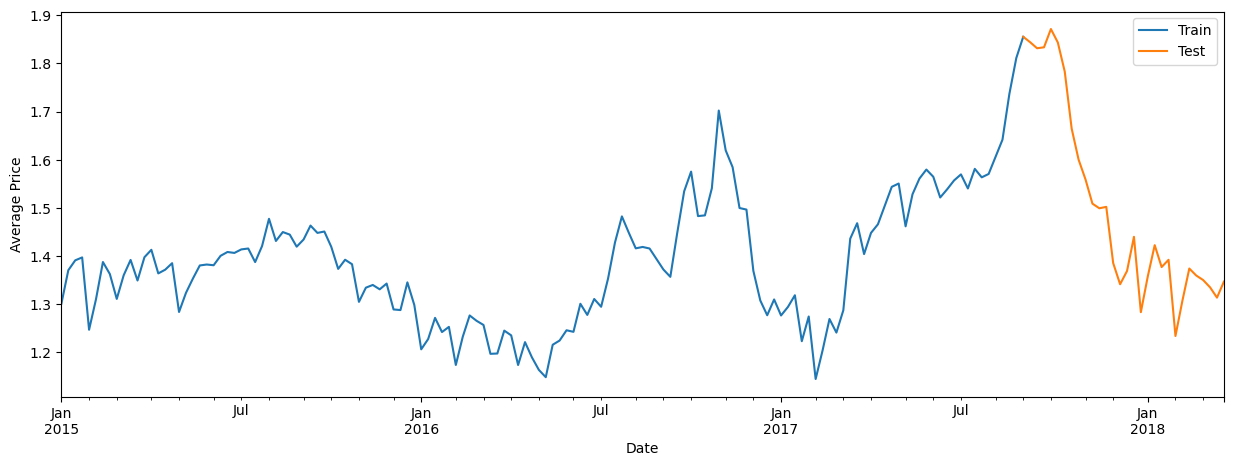

In [11]:
test_start_date = '2017-09-03'

train_data = df1.loc[:test_start_date]
test_data = df1.loc[test_start_date:]

ax = train_data.plot(figsize=(15, 5))
test_data.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()

## **Building ARIMA Model**

**Stationarity check**

In [12]:
result = adfuller(df1)

print(f"Test Statistic: { result[0]}")
print(f"P-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

Test Statistic: -2.3578165247666467
P-value: 0.15399792321893552
Non-Stationary


**First difference**

In [13]:
diff1 = df1.diff().dropna()

result = adfuller(diff1)

print(f"Test Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

Test Statistic: -13.199464270995634
P-value: 1.1020064201645545e-24
Stationary


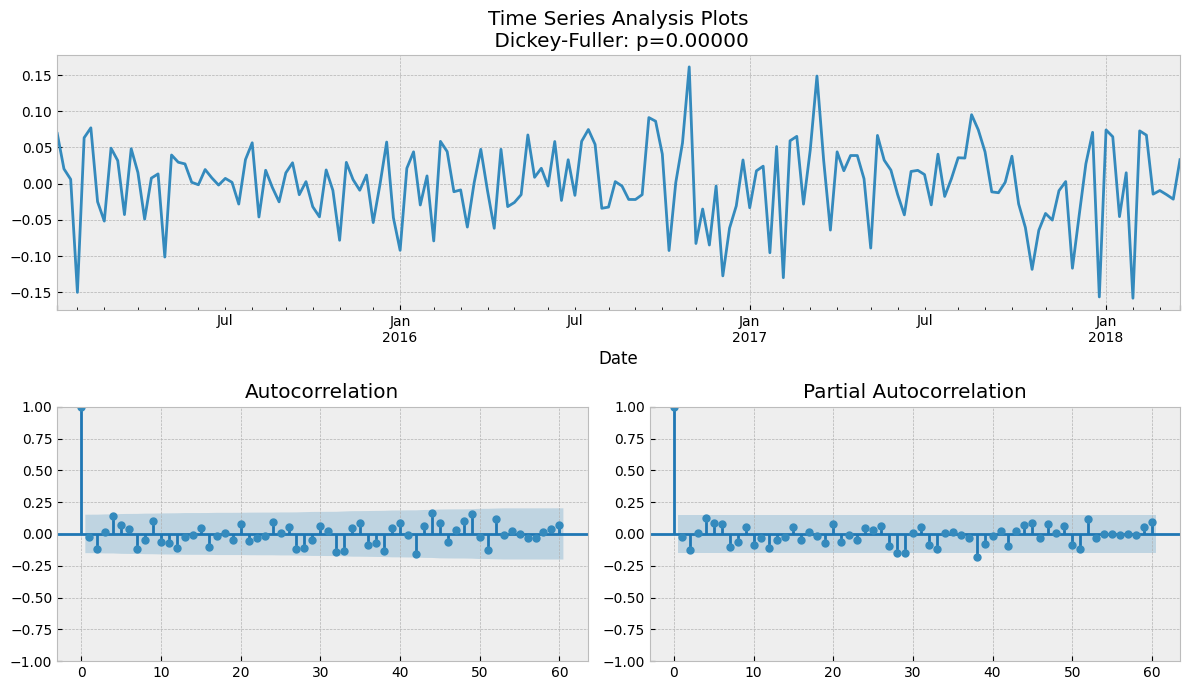

In [14]:
tsplot(diff1['AveragePrice'], lags=60)

In [15]:
arima = SARIMAX(train_data, order = (2,1,2)) 
arima_fit = arima.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           AveragePrice   No. Observations:                  140
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 221.484
Date:                Tue, 09 Jan 2024   AIC                           -432.968
Time:                        22:25:09   BIC                           -418.295
Sample:                    01-04-2015   HQIC                          -427.005
                         - 09-03-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6464      0.045     14.220      0.000       0.557       0.736
ar.L2         -0.9421      0.041    -22.922      0.000      -1.023      -0.862
ma.L1         -0.7450      0.051    -14.540      0.0

### **Long-term forecast**

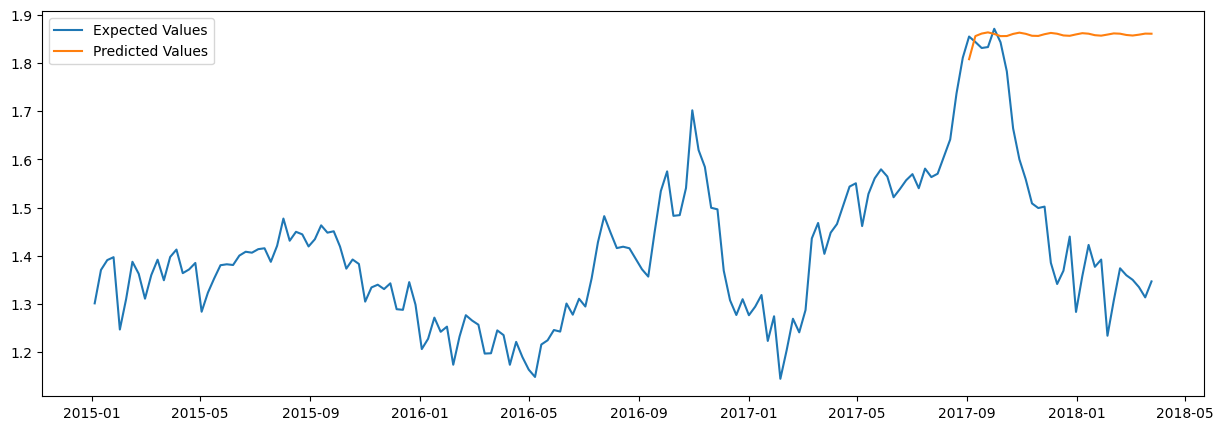

RMSE: 0.4083173045183557
R2: -2.9988026688861997


In [16]:
predictions = arima_fit.predict(start=test_start_date, end="2018-03-25")

predictions_plot(predictions, test_data, df1)

### **Rolling forecast**

In [17]:
history = [x for x in train_data['AveragePrice']]
predictions = []

for t in range(len(test_data['AveragePrice'])):

    model = SARIMAX(history, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_data['AveragePrice'][t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

predicted = 1.856116, expected = 1.855185
predicted = 1.860446, expected = 1.843889
predicted = 1.847180, expected = 1.831389
predicted = 1.829995, expected = 1.833333
predicted = 1.829990, expected = 1.871296
predicted = 1.867772, expected = 1.843333
predicted = 1.846363, expected = 1.782870
predicted = 1.791715, expected = 1.664537
predicted = 1.682292, expected = 1.600185
predicted = 1.619720, expected = 1.559074
predicted = 1.561514, expected = 1.508796
predicted = 1.515982, expected = 1.499167
predicted = 1.486422, expected = 1.502130
predicted = 1.493140, expected = 1.385370
predicted = 1.391411, expected = 1.341481
predicted = 1.350191, expected = 1.368981
predicted = 1.369653, expected = 1.439907
predicted = 1.423646, expected = 1.283519
predicted = 1.283052, expected = 1.357778
predicted = 1.375530, expected = 1.422593
predicted = 1.427081, expected = 1.377130
predicted = 1.364893, expected = 1.392222
predicted = 1.378875, expected = 1.234074
predicted = 1.245805, expected = 1

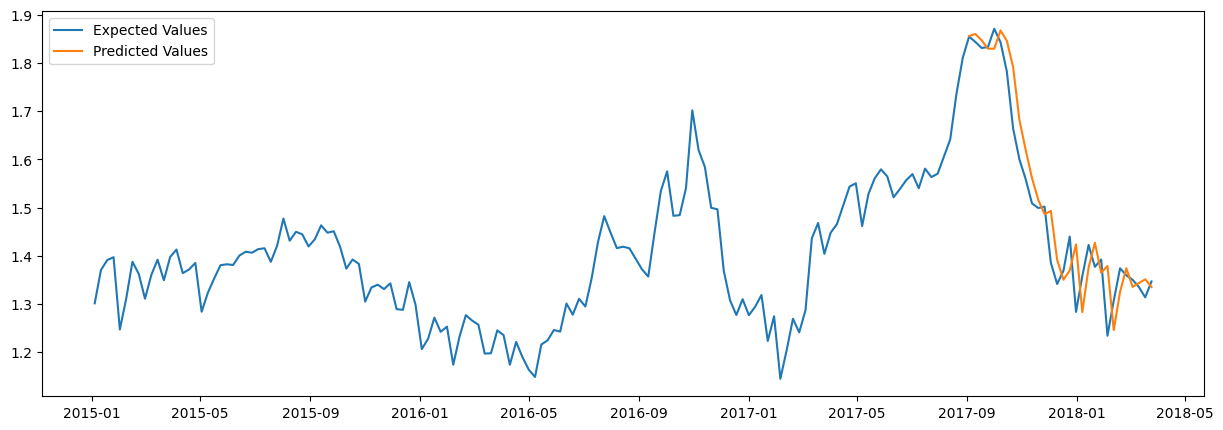

RMSE: 0.06217991420475052
R2: 0.9072669297714708


In [18]:
predictions_plot(pd.Series(predictions, index = test_data.index), test_data, df1)

## **Building SARIMA Model**

s = 52 since we have weekly data

**Seasonal difference**

In [19]:
diff1_s = diff1.diff(52).dropna()

result = adfuller(diff1_s)

print(f"Test Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

Test Statistic: -4.6785085801947615
P-value: 9.23336060207812e-05
Stationary


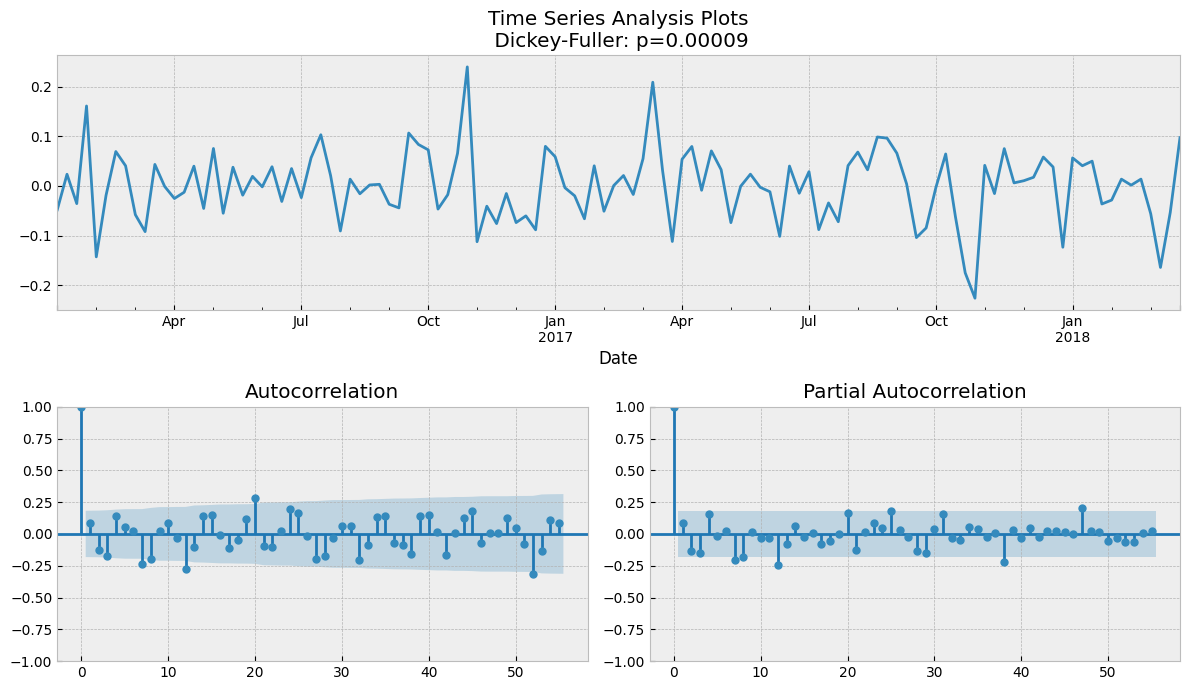

In [20]:
tsplot(diff1_s['AveragePrice'], lags=55)

In [21]:
sarima = SARIMAX(train_data, order = (2,1,2), seasonal_order=(0, 1, 1, 52))
sarima_fit = sarima.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         AveragePrice   No. Observations:                  140
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood                 116.755
Date:                              Tue, 09 Jan 2024   AIC                           -221.511
Time:                                      22:26:20   BIC                           -206.715
Sample:                                  01-04-2015   HQIC                          -215.553
                                       - 09-03-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6011      0.049     12.301      0.000       0.505       0.697
ar.L2         -0.99

### **Long-term forecast**

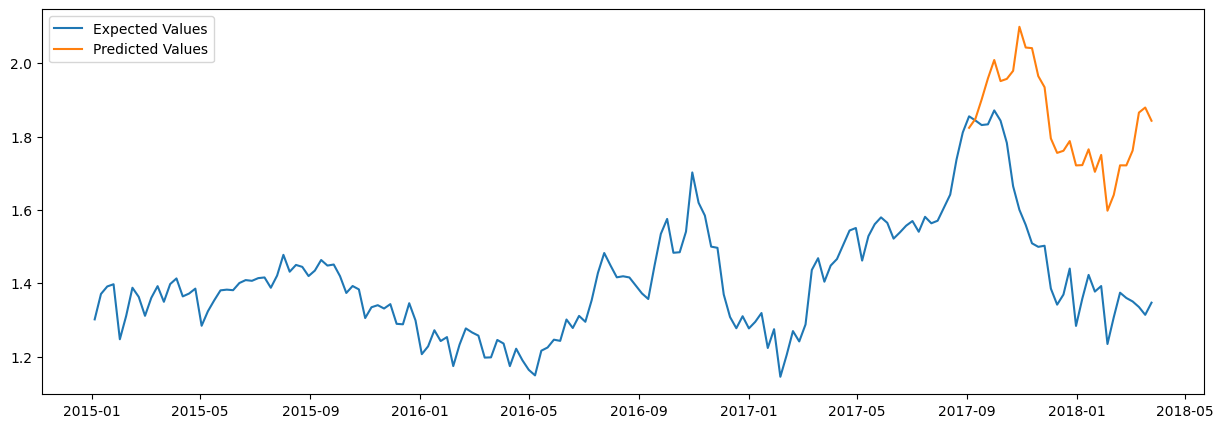

RMSE: 0.3721005107258884
R2: -2.3208933921059507


In [22]:
predictions = sarima_fit.predict(start=test_start_date, end="2018-03-25")

predictions_plot(predictions, test_data, df1)

### **Rolling forecast**

In [24]:
history = [x for x in train_data['AveragePrice']]
predictions = []

for t in range(len(test_data['AveragePrice'])):

    model = SARIMAX(history, order = (2,1,2), seasonal_order=(0, 1, 1, 52))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_data['AveragePrice'][t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

predicted = 1.848082, expected = 1.855185
predicted = 1.907299, expected = 1.843889
predicted = 1.901575, expected = 1.831389
predicted = 1.877645, expected = 1.833333
predicted = 1.782754, expected = 1.871296
predicted = 1.863833, expected = 1.843333
predicted = 1.847734, expected = 1.782870
predicted = 1.855980, expected = 1.664537
predicted = 1.670461, expected = 1.600185
predicted = 1.610410, expected = 1.559074
predicted = 1.503057, expected = 1.508796
predicted = 1.492716, expected = 1.499167
predicted = 1.401573, expected = 1.502130
predicted = 1.473538, expected = 1.385370
predicted = 1.394314, expected = 1.341481
predicted = 1.338341, expected = 1.368981
predicted = 1.317608, expected = 1.439907
predicted = 1.473243, expected = 1.283519
predicted = 1.348177, expected = 1.357778
predicted = 1.282321, expected = 1.422593
predicted = 1.421285, expected = 1.377130
predicted = 1.294973, expected = 1.392222
predicted = 1.459358, expected = 1.234074
predicted = 1.300069, expected = 1

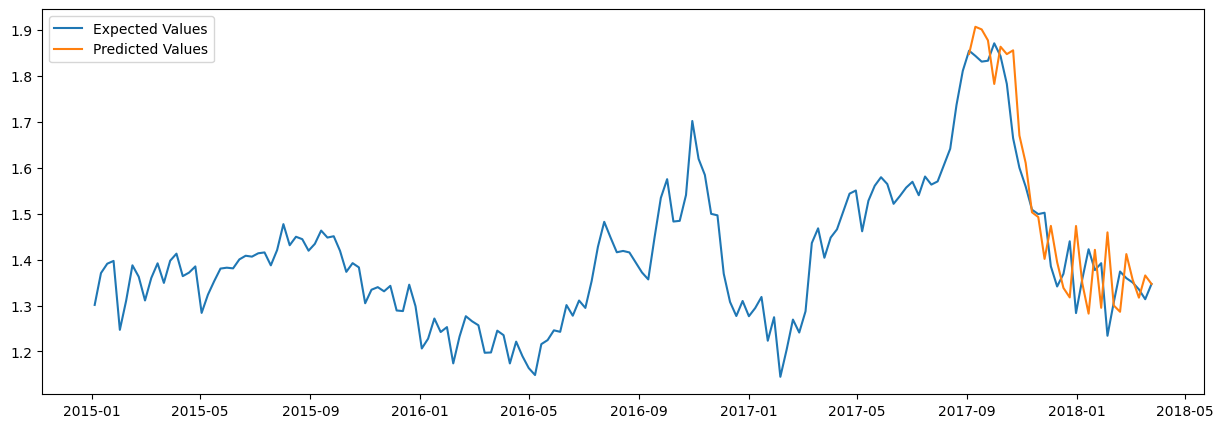

RMSE: 0.08864972281363433
R2: 0.8115096304906675


In [25]:
predictions_plot(pd.Series(predictions, index = test_data.index), test_data, df1)

### **Out-of-sample forecasting**

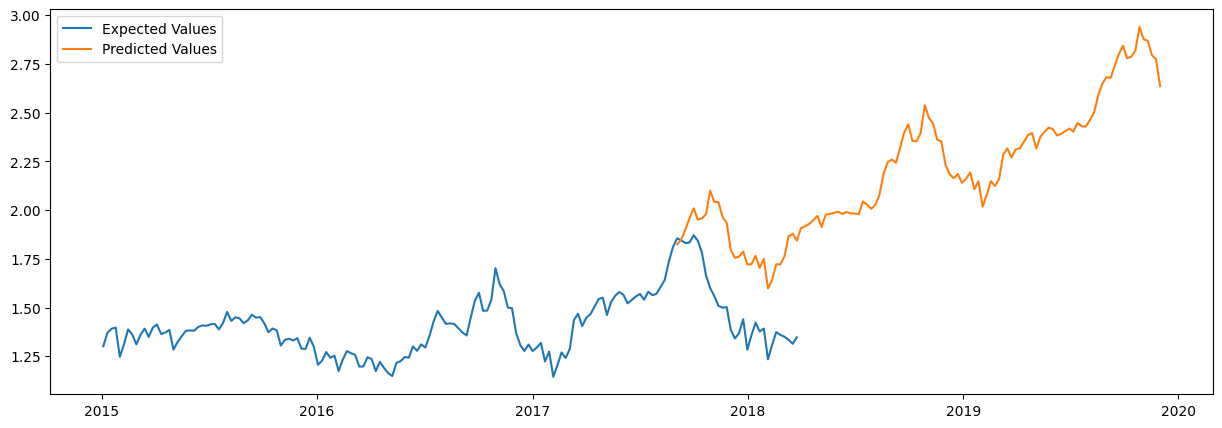

In [ ]:
from utils import predictions_plot as pp
predictions = sarima_fit.predict(start=test_start_date, end="2019-12")

pp(predictions, data=df1)

## **Export**

In [30]:
import pickle
import bz2

with bz2.BZ2File('../pkl/sarima.pkl', 'wb') as f:
    pickle.dump(sarima_fit, f)